# Lecture 14 - Neural Operators

In [ ]:
using Pkg
Pkg.activate(".")
Pkg.add(["Lux", "LuxCUDA", "Random", "Optimisers", "Zygote", "Statistics", "MLUtils", "ParameterSchedulers", "PyCall", "Printf", "CairoMakie"])

## Contents
1. [Introduction](#intro)
2. [The Fourier Transform](#ft)
3. [Fourier Neural Operators (FNOs)](#fno)
4. [Implementing an FNO from Scratch using Flux.jl](#flux)
5. [Spherical Fourier Neural Operators (SFNOs)](#sfno)
6. [Further Reading](#further-reading)

## 1. Neural Operators <a class="anchor" id="intro"></a>
### 1.1. Introduction

* Neural operators are a major development in scientific machine learning.

* **The defining property of neural operators is that they learn mappings between function spaces**.

* Regular neural networks learn mappings between fixed-dimensional spaces (e.g., classifying 224x224 pixel images into 1000 categories).

* Neural operators, on the other hand, learn mappings between functions defined on continuous domains (e.g., predicting how a fluid will flow given some initial conditions).

* This means neural operators can make predictions on any grid and at any resolution, _even those they weren't trained on_ - a huge advantage for scientific applications.


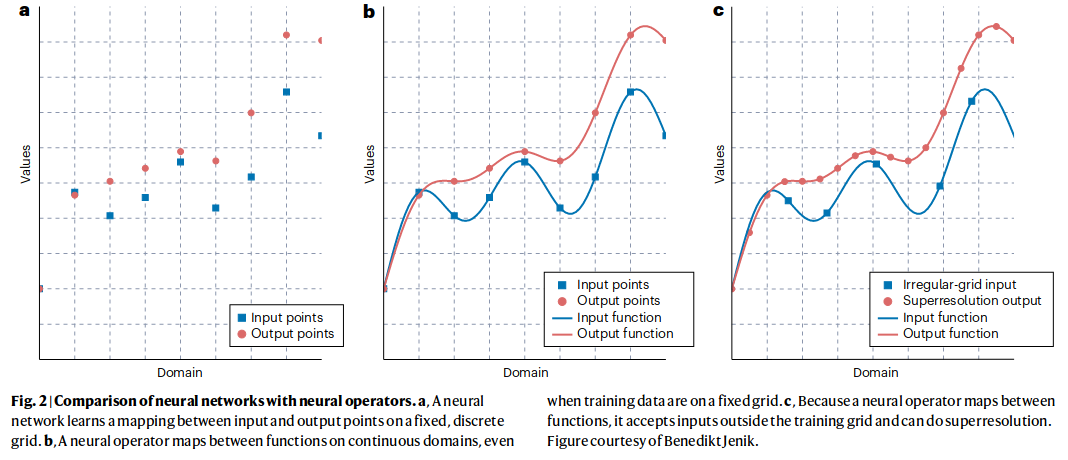
[Azizzadenesheli, K. et al. Neural operators for accelerating scientific simulations and design. Nat Rev Phys 6, 320–328 (2024). ](https://www.nature.com/articles/s42254-024-00712-5)

### 1.2. **Why They Matter**
* Many scientific problems involve solving partial differential equations (PDEs), which is computationally very expensive.

* Traditional numerical methods often require very fine computational grids and many iterations, for example, in order to satisfy CFL conditions.

* Neural operators can be trained as "surrogate models" or "emulators" of traditional PDE solvers and can **provide solutions up to 10,000x or 100,000x faster while maintaining high accuracy**.

* In weather forecasting, [FourCastNet](https://arxiv.org/abs/2202.11214v1) was one of the first AI weather models, and uses neural operators to provide forecasts several orders of magnitude faster than IFS, the leading numerical weather prediction (NWP) model.

* In climate modeling, powerful emulators are being built using neural operators, for example, [ACE](https://arxiv.org/abs/2310.02074) and [ACE2](https://arxiv.org/abs/2411.11268).

### 1.3. Problem Setup

* Consider a family of partial differential equations (PDEs) parameterized by a function $a(x)$.

* Input space: $\mathcal{A} = \{a: D \to \mathbb{R}^{d_a}\}$, $d_a$-dimensional functions on domain $D$.

* Output space: $\mathcal{U} = \{u: \Omega \to \mathbb{R}^{d_u}\}$, $d_u$-dimensional functions on domain $\Omega$.

* $\mathcal{A}$ and $\mathcal{U}$ are Banach spaces (a Banach space is a complete normed vector space).

* We want to learn the operator $\mathcal{G}: \mathcal{A} \to \mathcal{U}$ that maps input functions to output functions.

* Key insight: **This is infinite-dimensional! We're mapping between spaces of functions**.

### 1.4. General Architecture
* At the core of neural operators are linear integral layers of the form
$$\int \kappa(x,y)v(y)dy \approx \sum_{i}^N \kappa(x,y_i)v(y_i)\Delta y_i,$$
where $v(\cdot)$ is the input function to the operator block, and $\kappa(x,y)$ denotes a learnable kernel between any two points $x$ and $y$ in the output and input domains, respectively.

* Just as regular neural networks consist of sequences of linear transformations composed with nonlinear activation functions, neural operators consist of sequences of these linear integral layers also composed with nonlinear activation functions.

* One such neural operator block can be written:
$$
v_{l+1}(x) = \sigma\left(W v_l(x) + \int_D \kappa(x,y)v_l(y)dy\right)
$$

* Let's break this down:
  * $v_l(x)$ is the input function to this block.
  * Local part: $W v_l(x)$ handles point-wise transformations
    * $W \in \mathbb{R}^{d_{l+1} \times d_l}$ is a linear transformation
    * Analogous to standard neural network layer
  
  * Non-local part: $\int_D \kappa(x,y)v_l(y)dy$ captures global dependencies
    * $\kappa: \Omega \times D \to \mathbb{R}^{d_{l+1} \times d_l}$ is the kernel
    * Learnable function that determines how information at point $y$ influences point $x$
    * Integration over entire domain captures global context

  * Activation: GeLU often preferred over ReLU for smoothness

* In addition, we also need **lifting** and **projection** operators for changing the channel dimension.
  * **Lifting Operation:**
      * Initial transformation: $v_0(x) = P(a(x))$
      * $P: \mathbb{R}^{d_a} \to \mathbb{R}^{d_0}$ "lifts" the input to a higher dimension
      * Can be linear or nonlinear (nonlinear usually more expressive)
      * Usually pointwise MLPs
      
  * **Projection Operation:**
      * Final transformation: $u(x) = Q(v_L(x))$
      * $Q: \mathbb{R}^{d_L} \to \mathbb{R}^{d_u}$ projects back to output dimension
      * Usually simpler than lifting operation (often linear)
      * Usually pointwise MLPs


* We can now put all of this together into a **standard neural operator architecture:**
  1. Start with input function $a(x)$
  2. Lift the channel dimension to a higher dimensional space: $v_0(x) = P(a(x))$
  3. Apply sequence of nonlinear layers: $v_0 \to v_1 \to ... \to v_L$
  4. Project back to the output dimension: $u(x) = Q(v_L(x))$
  
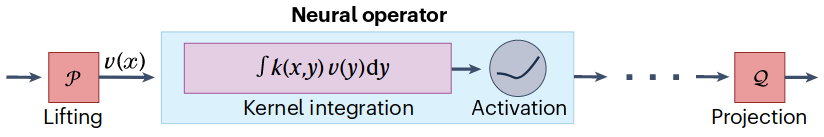
[Azizzadenesheli, K. et al. Neural operators for accelerating scientific simulations and design. Nat Rev Phys 6, 320–328 (2024). ](https://www.nature.com/articles/s42254-024-00712-5)

### 1.5. Discretization Convergence
* Neural operator approximates continuum operator even with discrete training.

* As grid gets finer ($N \to \infty$):
$$\int_D \kappa(x,y)v(y)dy \approx \sum_{i=1}^N \kappa(x,y_i)v(y_i)\Delta y_i$$

* Convergence theorem: Under appropriate conditions on $\kappa$, error → 0 as $N \to \infty$.

* As a consequence, we obtain **resolution invariance:**
  * Can input and output at any resolution
  * Enables zero-shot super-resolution

## 2. Reminder: The Fourier Transform <a class="anchor" id="ft"></a>
### 2.1. Continuous Fourier Transform
* The Fourier transform decomposes a function into an infinite sum of sinusoidal components. 

* For a function $f(x)$, its Fourier transform $\hat{f}(k)$ is:

    $$ \hat{f}(k) = \int_{-\infty}^{\infty} f(x)e^{-2\pi ikx}dx.$$

* The inverse transform is:

$$ f(x) = \int_{-\infty}^{\infty} \hat{f}(k)e^{2\pi ikx}dk. $$

* The Fourier transform gives us the ability to represent data in the frequency domain.

* Key properties:
    - Linearity: $\mathcal{F}[af + bg] = a\mathcal{F}[f] + b\mathcal{F}[g]$
    - Translation: $\mathcal{F}[f(x-a)] = e^{-2\pi ika}\hat{f}(k)$
    - Scaling: $\mathcal{F}[f(ax)] = \frac{1}{|a|}\hat{f}(k/a)$
    - **Convolution**: $\mathcal{F}[f * g] = \mathcal{F}[f] \cdot \mathcal{F}[g]$

### 2.2. Discrete Fourier Transform (DFT)

* For a sequence of N samples $x[n]$, the DFT is:

$$ X[k] = \sum_{n=0}^{N-1} x[n]e^{-2\pi ikn/N} .$$

* The inverse DFT is:

$$ x[n] = \frac{1}{N}\sum_{k=0}^{N-1} X[k]e^{2\pi ikn/N} .$$

* The sampling rate $f_s = 1/\Delta t$ determines the highest frequency that can be represented in the discrete signal. The Nyquist frequency is:

$$ f_{Nyquist} = \frac{f_s}{2} = \frac{1}{2\Delta t} $$


* This fundamental limit means:
    - Frequencies above $f_{Nyquist}$ will be aliased (appear as lower frequencies)
    - To accurately represent a signal with highest frequency component $f_{max}$, we need $f_s > 2f_{max}$
    
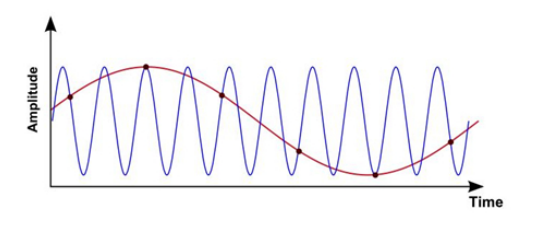
[Source](https://dataphysics.com/blog/dynamic-signal-analysis/dynamic-signal-analysis-review-part-3-aliasing/)


* When a signal contains frequencies above $f_{Nyquist}$, they appear folded back into the lower frequency range:

$$ f_{aliased} = |f_{true} - n\cdot f_s|, $$
where $n$ is the integer that minimizes this difference.

* To prevent aliasing:
    * Sample at a sufficiently high rate
    * Ensure input signals are bandlimited

### 2.3. Fast Fourier Transform (FFT)

* The FFT is an efficient algorithm to compute the DFT, reducing complexity from $O(N^2)$ to $O(N\log N)$.

* The key insight is to recursively break down a DFT of size $N$ into $N_1$ smaller DFTs of size $N_2$ such that $N = N_1N_2$. This kind of strategy is known as "divide and conquer".

* For $N$ a power of 2, one of the most common and simplest DFTs involves splitting the sum into even and odd indices:

$$ X[k] = \sum_{n=0}^{N-1} x[n]e^{-2\pi ikn/N} $$
$$ = \sum_{m=0}^{N/2-1} x[2m]e^{-2\pi ik(2m)/N} + \sum_{m=0}^{N/2-1} x[2m+1]e^{-2\pi ik(2m+1)/N} $$
$$ = \sum_{m=0}^{N/2-1} x[2m]e^{-2\pi ikm/(N/2)} + e^{-2\pi ik/N}\sum_{m=0}^{N/2-1} x[2m+1]e^{-2\pi ikm/(N/2)} $$
$$ = X_{\text{even}}[k] + W_N^k X_{\text{odd}}[k] $$

where $W_N = e^{-2\pi i/N}$ is the "twiddle factor".

### 2.4. Beyond 1-D 
* For a 2D function $f(x,y)$, its Fourier transform is:

$$ f(k_x,k_y) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty} f(x,y)e^{-2\pi i(k_xx + k_yy)}dxdy $$

* This double integral can be computed as nested single integrals:

$$ f(k_x,k_y) = \int_{-\infty}^{\infty}\left(\int_{-\infty}^{\infty} f(x,y)e^{-2\pi ik_xx}dx\right)e^{-2\pi ik_yy}dy $$

* This means we can:

    1. First compute the 1D transform along x for each y
    2. Then compute the 1D transform along y of the intermediate result
<br>

* For a discrete image $f[n,m]$ of size $N \times M$, the 2D DFT is:

$$ f[k,l] = \sum_{n=0}^{N-1}\sum_{m=0}^{M-1} f[n,m]e^{-2\pi i(\frac{kn}{N} + \frac{lm}{M})} $$


* Which can be separated into:

$$ f[k,l] = \sum_{m=0}^{M-1}\left(\sum_{n=0}^{N-1} f[n,m]e^{-2\pi i\frac{kn}{N}}\right)e^{-2\pi i\frac{lm}{M}} $$

* So we just do a DFT in each direction.

* This generalizes straightforwardly to $N$-dimensions.

## 3. Fourier Neural Operators <a class="anchor" id="fno"></a>

* The Fourier Neural Operator (FNO) is a particularly efficient architecture that leverages the power of the Fourier transform to capture global dependencies.

* **The key innovation of FNO is to replace the general integral operator we saw earlier with a convolution operator defined in Fourier space**.

* Reminder: A convolution operator is a type of integral transform that combines two functions. For functions $f$ and $g$, their convolution $(f * g)$ is defined as:
$$(f * g)(x) = \int_D f(x-y)g(y)dy.$$

* Intuitively, convolution measures the overlap between one function and a shifted version of another. It is translation equivariant (shifting input shifts output) and applies the same operation across the entire domain.

* In the context of neural operators, we use a learned kernel function $\kappa_\phi$ and convolve it with our input function $v$:
$$(\kappa_\phi * v)(x) = \int_D \kappa_\phi(x-y)v(y)dy.$$

* This is a natural choice because many physical processes are translation equivariant and the same physical laws apply throughout the domain.

* **Why do the convolution in Fourier space? The key insight comes from the convolution theorem, which states that convolution in physical space equals multiplication in Fourier space**:
$$(f * g)(x) = \mathcal{F}^{-1}(\mathcal{F}f \cdot \mathcal{F}g)$$

* To see why this is efficient, first consider doing the convolution on a discretized domain with $n$ points:
    1. Need to compute integral for each point
    2. Each integral requires summing over all other points
    3. Total complexity: $O(n^2)$
<br><br>

* Instead, using the Fourier Transform:
    1. Transform to Fourier space: $O(n \log n)$ using FFT
    2. Pointwise multiplication: $O(n)$
    3. Transform back: $O(n \log n)$
    4. Total complexity: $O(n \log n)$
<br><br>

* The Fourier layer is then defined as:
$$(\mathcal{K}(\phi)v_t)(x) = \mathcal{F}^{-1}(R_\phi \cdot (\mathcal{F}v_t))(x)$$

    where $R_\phi$ is a learnable filter acting in Fourier space.

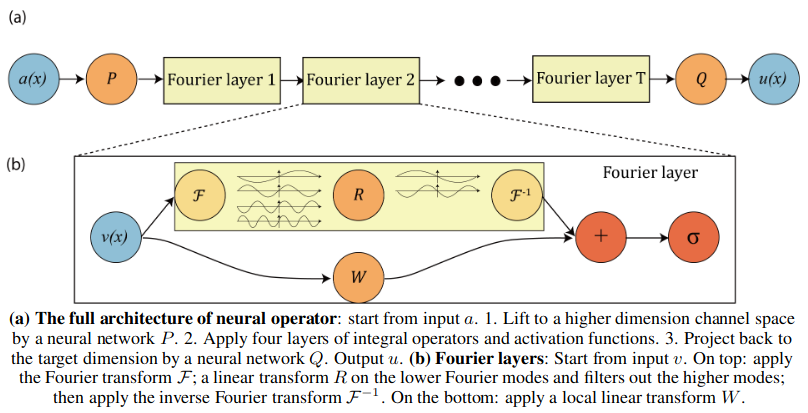

[Li et al. Fourier Neural Operator for Parametric Partial Differential Equations (2021)](https://openreview.net/forum?id=c8P9NQVtmnO)

### Practical Considerations

* Choice of $k_{max}$
* Channel dimension $d_v$
* Activation function: GeLU often preferred over ReLU for smoothness

## 4. Implementing an FNO from Scratch using Flux.jl <a class="anchor" id="flux"></a>
* Let's put this into practice and implement our own FNO using Flux.jl.

* There's already a Julia package called [NeuralOperators.jl](https://github.com/SciML/NeuralOperators.jl), but
    1. It is a very minimal implementation and is missing some key features.
    2. It uses Lux.jl, which we don't cover in this course, rather than Flux.jl.
<br><br>

* We will attempt to reproduce the [Darcy Flow](https://neuraloperator.github.io/dev/auto_examples/plot_FNO_darcy.html) example from the official Python implementation of neural operators.

* Darcy's law describes fluid flow through porous media.

* In its basic form, it states that the flow rate is proportional to the pressure gradient:

$$\mathbf{q} = -\frac{k}{\mu}\nabla p$$

where:
- $\mathbf{q}$ is the Darcy flux (volumetric flow rate per unit area)
- $k$ is the permeability of the medium
- $\mu$ is the fluid viscosity
- $\nabla p$ is the pressure gradient

* When combined with mass conservation, this gives the pressure equation:

$$\nabla \cdot \left(-\frac{k}{\mu}\nabla p\right) = f$$

where $f$ represents sources/sinks.

* This equation is fundamental in modeling groundwater flow, oil/gas reservoirs, and geothermal systems.

* The dataset we will use consists of a masks (ones and zeros) determining where the medium is, and steady state pressure values.

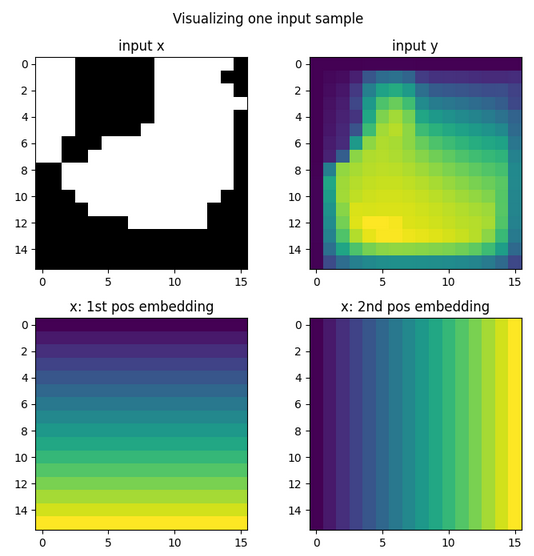

In [30]:
using Flux, Zygote, FFTW, NNlib, ChainRulesCore, CUDA, ParameterSchedulers, Printf, Statistics

### 4.1. Spectral Convolution Layer
* We first imlement the spectral convolution layer, i.e.,
$$(\mathcal{K}(\phi)v_t)(x) = \mathcal{F}^{-1}(R_\phi \cdot (\mathcal{F}v_t))(x)$$

* All we need to do is:
    1. FFT the input function
    2. Multiply with the learned weights in the frequency domain
    3. Inverse FFT back to the grid domain

In [31]:
"""
    SpectralConv{T,N,W}
Spectral convolution layer for Fourier Neural Operator implementation in Flux.jl.
Expects input in (spatial..., channel, batch) format.
"""
struct SpectralConv{T,N,W<:AbstractArray{T}}
    weight::W
    modes::NTuple{N,Int}
end

# Constructor
function SpectralConv(in_channels::Integer, out_channels::Integer, modes::NTuple{N,Integer}) where N
    init_std = sqrt(2f0 / (in_channels + out_channels))  # Standard Glorot-like scaling
    weight = init_std * randn(ComplexF32, modes..., out_channels, in_channels)
    return SpectralConv{ComplexF32,N,typeof(weight)}(weight, modes)
end

# Convenience constructor using Pair syntax
SpectralConv(ch::Pair{<:Integer,<:Integer}, modes::NTuple{N,Integer}) where N = SpectralConv(first(ch), last(ch), modes)

"""
    low_pass(x_ft, modes)

Apply a low-pass filter to a Fourier-transformed array by retaining only the lowest frequency modes.

# Arguments
- `x_ft`: A Fourier-transformed array with at least 2 trailing dimensions
- `modes`: A tuple or array specifying the number of low-frequency modes to keep along each leading dimension

# Returns
- A view of the input array `x_ft` containing only the specified low-frequency modes, preserving the last two dimensions in full

# Details
The function creates a view that selects the first `modes[i]` elements along each leading dimension `i`,
while keeping all elements of the last two dimensions. This effectively implements a low-pass filter
in Fourier space by truncating high-frequency modes.
"""
function low_pass(x_ft, modes)
    return view(x_ft, map(d -> 1:d, modes)..., :, :)
end

"""
    apply_pattern(x_tr::AbstractArray{T,N}, weights::AbstractArray{T,3}) where {T,N}

Apply learned weight patterns to truncated Fourier coefficients.

# Arguments
- `x_tr::AbstractArray{T,N}`: Truncated Fourier coefficients after low-pass filtering, with shape (modes..., in_channels, batch)
- `weights::AbstractArray{T,4}`: Complex-valued learned weights with shape (modes..., out_channels, in_channels)

# Returns
- Weighted Fourier coefficients with shape (modes..., out_channels, batch)
"""
function apply_pattern(x_tr::AbstractArray{T,N}, weights::AbstractArray{T}) where {T,N}
    # Insert new axis for out_channels before batch dimension
    x_expanded = reshape(x_tr, size(x_tr)[1:N-2]..., 1, size(x_tr)[N-1:N]...)
    
    # Now shapes will be:
    # x_expanded: (mode1, mode2, 1, in_channels, batch)
    # weights:    (mode1, mode2, out_channels, in_channels)
    
    # Contract over in_channels dimension
    return dropdims(sum(weights .* x_expanded, dims=N), dims=N)
end

"""
    expand_pad_dims(pad_dims::Dims{N}) where {N}

Convert N-dimensional padding specification into format required for NNlib's pad_constant function.

# Arguments
- `pad_dims::Dims{N}`: Tuple of N integers specifying the total padding needed along each dimension

# Returns
- `NTuple{2N,Int}`: Tuple of 2N integers specifying padding for both sides of each dimension,
  where padding is applied only at the end of each dimension (start padding is always 0)
"""
function expand_pad_dims(pad_dims::Dims{N}) where {N}
    return ntuple(i -> isodd(i) ? 0 : pad_dims[i ÷ 2], 2N)
end
@non_differentiable expand_pad_dims(::Any)

# Main forward pass
function (layer::SpectralConv)(x)
    # Apply Fourier transform on the spatial dimensions
    x_ft = fft(x, 1:ndims(x)-2)  # Last two dims are channel and batch, only FFT on spatial dims
    
    # Truncate modes and apply weights
    x_tr = low_pass(x_ft, layer.modes)  # Should this be before or after? Check.
    x_p = apply_pattern(x_tr, layer.weight)
    
    # Pad the result back to original size
    pad_dims = size(x_ft)[1:(end - 2)] .- size(x_p)[1:(end - 2)]
    x_padded = NNlib.pad_constant(x_p, expand_pad_dims(pad_dims), false; dims=ntuple(identity, ndims(x_p) - 2))
    
    # Inverse Fourier transform
    return real(ifft(x_padded, 1:ndims(x_padded)-2))
end

# Make the layer compatible with Flux's training
Flux.@layer SpectralConv

In [34]:
x = randn(Float32, 16, 16, 3, 32)  # (height, width, channels, batch)    
conv = SpectralConv(3 => 3, (16, 16))
conv(x)

16×16×3×32 Array{Float32, 4}:
[:, :, 1, 1] =
 -1.5944     -0.102632    0.784583  …  -0.282419    0.864759   -0.360728
  0.0722064   0.0920608   0.308042     -0.645523   -0.0263477  -0.206146
  1.01104    -1.46676    -0.483289      0.734895    0.408165    0.822402
  0.822909   -1.10377     0.364394      0.234897   -1.63592    -0.507234
  0.783401    0.537762   -0.610889      0.0650343  -0.506832   -1.17438
 -0.596523    0.0377483  -0.698427  …  -0.221616   -0.107683   -0.765704
  1.03137     0.686711    0.489503     -0.446677   -1.28554    -0.633866
  0.733128    1.97469    -1.28605      -0.923748    0.47759     0.975137
 -0.618501    1.12369     0.320616      0.354154   -0.33392    -0.332412
  2.26867    -0.929798    0.150773     -0.647711   -0.683689   -0.692966
 -0.490966    0.350648   -0.045955  …  -1.80946     0.635658    0.875484
 -0.742354    0.031731   -0.792553     -0.776594   -0.769832   -0.0149656
  0.0904142   0.621238   -0.783279     -0.169954    0.700012   -0.0679766
  0.8

### 4.2. Spectral Kernel Layer
* We then combine the spectral convolution layer with a parallel operation in grid-space to form the overall _spectral kernel layer_.

* In practice, we usually do a 1x1 convolution.

In [35]:
"""
    SpectralKernel{P,F}

Combines a SpectralConv layer with a 1x1 convolution in parallel, followed by an activation function.
Expects input in (spatial..., channel, batch) format.
"""
struct SpectralKernel{P,F}
    parallel::P  # Parallel(+, spatial_conv, spectral_conv)
    activation::F # Activation function
end

# Constructor
function SpectralKernel(ch::Pair{<:Integer,<:Integer}, modes::NTuple{N,Integer}, activation=gelu) where N
    in_ch, out_ch = ch
    
    # Create 1x1 convolution with kernel size 1
    conv = Conv((1,1), in_ch => out_ch, pad=0)
    
    # Create spectral convolution
    spectral = SpectralConv(ch, modes)
    
    # Combine using Parallel
    parallel = Parallel(+, conv, spectral)
    
    return SpectralKernel(parallel, activation)
end

# Forward pass
function (layer::SpectralKernel)(x::AbstractArray)
    layer.activation.(layer.parallel(x))
end

# Make the layer compatible with Flux's training
Flux.@layer SpectralKernel

In [36]:
x = randn(Float32, 16, 16, 3, 32)  # (height, width, channels, batch)    
kernel = SpectralKernel(3 => 3, (9, 16))
kernel(x)

16×16×3×32 Array{Float32, 4}:
[:, :, 1, 1] =
 -0.13044     0.264727    0.243135   …  -0.0823996   1.08191    -0.0473485
 -0.0524222   1.97228     0.449616      -0.0675815   0.0170159  -0.116975
 -0.168094    0.0232932  -0.169825       0.324082   -0.145972   -0.130722
 -0.0493282   0.474387   -0.0165516     -0.168585    0.613944    1.55425
 -0.14001     0.494527   -0.168114       0.126947    0.144721    0.232197
 -0.0130074  -0.0576231  -0.068592   …  -0.0342647  -0.050081   -0.090719
 -0.0627633   0.787966    0.603848      -0.0276591  -0.169944    0.676708
  0.670876    0.6029     -0.143241      -0.0443845   1.06585    -0.169415
 -0.108276   -0.108035    0.352411      -0.160188    1.98037    -0.167911
  1.00799    -0.142438    0.0154653      2.10428    -0.108419   -0.0230618
  0.051111    0.17691    -0.0960833  …   0.96016     0.215377    0.214965
 -0.139385   -0.0480558   1.48938        0.521501    0.0140927   0.848836
 -0.137      -0.0123279  -0.169415      -0.124602    0.0161581  -0

### 4.3. Channel MLPs
* For additional expressivity and channel mixing, we implement channel MLPs that act pointwise in the spatial domain.

* Channel MLPs are applied immediately after the spectral kernel.

* Channel MLPs are usually also combined with a skip connection; we will use soft gating.

* Soft gating modulates the skip connection by learning a scaling factor $w \cdot x$, where $w$ is a learned weight, allowing the network to smoothly control how much of the original input passes through versus the transformed features from the channel MLP.

In [37]:
# Soft gating layer implementation
struct SoftGating
    channels::Int
    weight::AbstractArray
end

# Constructor for SoftGating
function SoftGating(channels::Int)
    weight = ones(Float32, 1, 1, channels, 1)
    return SoftGating(channels, weight)
end

# Forward pass for SoftGating
function (sg::SoftGating)(x)
    return sg.weight .* x
end

Flux.@layer SoftGating trainable =(weight,)

* The Channel MLPs themselves are just 1x1 convolutions (or equivalently, pointwise MLPs).

In [38]:
# Parallel layer for combining channel MLP and skip connection
struct ChannelMLP{M,S}
    mlp::M
    skip::S
end

# Forward pass for ChannelMLP
function (p::ChannelMLP)(x)
    return p.mlp(x) + p.skip(x)
end

# Main ChannelMLP constructor
function ChannelMLP(channels::Int; expansion_factor=0.5, activation=gelu)
    mlp = Chain(
        Conv((1, 1), channels => Int(expansion_factor * channels), activation),
        Conv((1, 1), Int(expansion_factor * channels) => channels)
    )
    
    return ChannelMLP(
        mlp,
        SoftGating(channels),
    )
end

# Make the layers compatible with Flux's training utilities
Flux.@layer ChannelMLP trainable=(mlp, skip)

### 4.4. Grid Embedding
* We can encode information about the spatial location of each point by adding grid embedding as additional channels.

In [ ]:
# Positional embedding
function meshgrid(x, y)
  return (repeat(x, 1, length(y)), repeat(y', length(x), 1))
end

struct GridEmbedding2D
  boundaries_x::Vector{Float32}
  boundaries_y::Vector{Float32}
end

function GridEmbedding2D(grid_boundaries=[[0f0, 1f0], [0f0, 1f0]])
  return GridEmbedding2D(grid_boundaries[1], grid_boundaries[2])
end

ChainRulesCore.@non_differentiable LinRange{Float32,Int64}(start::Float32, stop::Float32, length::Int64)

function (ge::GridEmbedding2D)(x)
    height, width, channels, batch_size = size(x)

    x_range = LinRange(ge.boundaries_x..., height)
    y_range = LinRange(ge.boundaries_y..., width)
    grid_x, grid_y = meshgrid(x_range, y_range)
    
    grid_x = reshape(grid_x, (height, width, 1, 1))
    grid_x = repeat(grid_x, outer = (1, 1, 1, batch_size)) |> get_device(x)
    
    grid_y = reshape(grid_y, (height, width, 1, 1))
    grid_y = repeat(grid_y, outer = (1, 1, 1, batch_size)) |> get_device(x)
    
    return cat(x, grid_x, grid_y, dims=length(size(x))-1)
end

@non_differentiable (::GridEmbedding2D)(::Any)

### 4.5. Fourier Neural Operator

In [39]:
struct FourierNeuralOperator{M}
    model::M
end
Flux.@layer FourierNeuralOperator

# Forward pass for FNO
function (fno::FourierNeuralOperator)(x)
    return fno.model(x)
end

# Use exact same API as Python library
function FourierNeuralOperator(
  ;
  activation=gelu,
  in_channels,
  out_channels,
  hidden_channels=32,
  n_modes=(16, 16),  # Number of modes to keep in frequency domain
  n_layers=4,  # Number of spectral kernel layers
  lifting_channel_ratio=2,
  projection_channel_ratio=2,
  channel_mlp_expansion=0.5,
  positional_embedding="grid",
)
  n_dim = length(n_modes)
  if positional_embedding == "grid"
    embedding = GridEmbedding2D()
    in_channels += n_dim
  end

  lifting = Chain(
      Conv((1, 1), in_channels => Int(lifting_channel_ratio * hidden_channels), activation),
      Conv((1, 1), Int(lifting_channel_ratio * hidden_channels) => hidden_channels, activation),
  )
  projection = Chain(
      Conv((1, 1), hidden_channels => Int(projection_channel_ratio * hidden_channels), activation),
      Conv((1, 1), Int(projection_channel_ratio * hidden_channels) => out_channels, activation),
  )
  fno_blocks = Chain([
      Chain(
          SpectralKernel(hidden_channels => hidden_channels, n_modes, activation),
          ChannelMLP(hidden_channels; expansion_factor=channel_mlp_expansion, activation=activation),
      ) for i in 1:n_layers
  ]...)
  
  return FourierNeuralOperator(Chain(; positional_embedding=embedding, lifting, fno_blocks, projection))
end

FourierNeuralOperator

In [40]:
fno = FourierNeuralOperator(
    in_channels=1,
    out_channels=1,
    hidden_channels=32,
    n_modes=(16,16),
    );

### 4.6. Data

In [41]:
using PyCall, MLUtils

torch = pyimport("torch")

# Train data
darcy_train_16 = torch.load("/p/tmp/alistair/TUM-Dynamics-Lecture/lectures/lecture-13/assets/darcy_train_16.pt", weights_only=true)
x_train = darcy_train_16["x"].numpy()
y_train = darcy_train_16["y"].numpy()

x_train = permutedims(x_train, [2, 3, 1])
x_train = reshape(x_train, size(x_train)[1:end-1]..., 1, size(x_train)[end])
x_train = x_train

y_train = permutedims(y_train, [2, 3, 1])
y_train = reshape(y_train, size(y_train)[1:end-1]..., 1, size(y_train)[end])
y_train = y_train

# Test data
darcy_test_16 = torch.load("/p/tmp/alistair/TUM-Dynamics-Lecture/lectures/lecture-13/assets/darcy_test_16.pt", weights_only=true)
x_test = darcy_test_16["x"].numpy()
y_test = darcy_test_16["y"].numpy()

x_test = permutedims(x_test, [2, 3, 1])
x_test = reshape(x_test, size(x_test)[1:end-1]..., 1, size(x_test)[end])
x_test = x_test

y_test = permutedims(y_test, [2, 3, 1])
y_test = reshape(y_test, size(y_test)[1:end-1]..., 1, size(y_test)[end])
y_test = y_test;

In [43]:
size(x_train)

(16, 16, 1, 1000)

In [44]:
size(x_test)

(16, 16, 1, 50)

In [42]:
dl = DataLoader((x_train, y_train); batchsize=32)

32-element DataLoader(::Tuple{Array{Bool, 4}, Array{Float32, 4}}, batchsize=32)
  with first element:
  (16×16×1×32 Array{Bool, 4}, 16×16×1×32 Array{Float32, 4},)

### 4.7. Training

In [45]:
# Put the model and the data on the GPU
device = gpu_device()
fno = device(fno)
dl = device(dl)

32-element DataLoader(::MLUtils.MappedData{:auto, CUDADevice{Nothing}, Tuple{Array{Bool, 4}, Array{Float32, 4}}}, batchsize=32)
  with first element:
  (16×16×1×32 CuArray{Bool, 4, CUDA.DeviceMemory}, 16×16×1×32 CuArray{Float32, 4, CUDA.DeviceMemory},)

In [46]:
mse(m, x, y) = mean(abs2, m(x) .- y)
opt_state = Flux.setup(AdamW(eta = 1f-4, lambda = 1f-4), fno)

num_epochs = 200
scheduler = CosAnneal(1f-4, 0f0, num_epochs, false)

CosAnneal{Float32, Int64}(0.0001f0, 0.0f0, 200, false)

In [47]:
for (epoch, learning_rate) in zip(1:num_epochs, scheduler)
    Optimisers.adjust!(opt_state, learning_rate)
    epoch_loss = 0f0
    num_batches = 0
    
    for (i, d) in enumerate(dl)
        (x, y) = d
        loss, gradients = Zygote.withgradient(m -> mse(m, x, y), fno)
        opt, model = Optimisers.update!(opt_state, fno, gradients[1])

        epoch_loss += loss
        num_batches += 1
    end

    avg_epoch_loss = epoch_loss / num_batches
    @printf("Epoch %3d | LR: %.2e | Avg Loss: %.4f\n", epoch, learning_rate, avg_epoch_loss)
end

Epoch   1 | LR: 1.00e-04 | Avg Loss: 0.2448
Epoch   2 | LR: 1.00e-04 | Avg Loss: 0.1675
Epoch   3 | LR: 1.00e-04 | Avg Loss: 0.0993
Epoch   4 | LR: 9.99e-05 | Avg Loss: 0.0736
Epoch   5 | LR: 9.99e-05 | Avg Loss: 0.0416
Epoch   6 | LR: 9.98e-05 | Avg Loss: 0.0284
Epoch   7 | LR: 9.98e-05 | Avg Loss: 0.0254
Epoch   8 | LR: 9.97e-05 | Avg Loss: 0.0244
Epoch   9 | LR: 9.96e-05 | Avg Loss: 0.0235
Epoch  10 | LR: 9.95e-05 | Avg Loss: 0.0227
Epoch  11 | LR: 9.94e-05 | Avg Loss: 0.0218
Epoch  12 | LR: 9.93e-05 | Avg Loss: 0.0209
Epoch  13 | LR: 9.91e-05 | Avg Loss: 0.0200
Epoch  14 | LR: 9.90e-05 | Avg Loss: 0.0190
Epoch  15 | LR: 9.88e-05 | Avg Loss: 0.0180
Epoch  16 | LR: 9.86e-05 | Avg Loss: 0.0171
Epoch  17 | LR: 9.84e-05 | Avg Loss: 0.0162
Epoch  18 | LR: 9.82e-05 | Avg Loss: 0.0154
Epoch  19 | LR: 9.80e-05 | Avg Loss: 0.0147
Epoch  20 | LR: 9.78e-05 | Avg Loss: 0.0140
Epoch  21 | LR: 9.76e-05 | Avg Loss: 0.0133
Epoch  22 | LR: 9.73e-05 | Avg Loss: 0.0128
Epoch  23 | LR: 9.70e-05 | Avg L

### 4.8. Testing

In [49]:
x_test = device(x_test)
pred = fno(x_test)

16×16×1×50 CuArray{Float32, 4, CUDA.DeviceMemory}:
[:, :, 1, 1] =
 -0.00178237  0.0145022  0.0347753  …  -0.010394   0.0336385  0.0446049
  0.00246238  0.259239   0.40835        0.102134   0.0804179  0.058151
  0.0196942   0.403531   0.621124       0.112571   0.102109   0.071677
  0.00699253  0.441188   0.750021       0.160032   0.0920147  0.0662985
  0.0224951   0.53971    0.819075       0.152586   0.116645   0.0812909
  0.00670457  0.530204   0.933553   …   0.195846   0.10909    0.0955742
  0.00132098  0.50889    0.877522       0.198976   0.134613   0.0918157
  0.0126069   0.442851   0.75116        0.2053     0.132136   0.0961702
  0.0359694   0.337592   0.498983       0.200536   0.145843   0.0849814
  0.0299334   0.168653   0.326116       0.193251   0.149898   0.0915056
  0.025708    0.147166   0.256222   …   0.191584   0.135914   0.0678635
 -0.0137417   0.165737   0.347153       0.188568   0.118247   0.0589125
 -0.00608604  0.323976   0.527147       0.16295    0.0872708  0.0146206


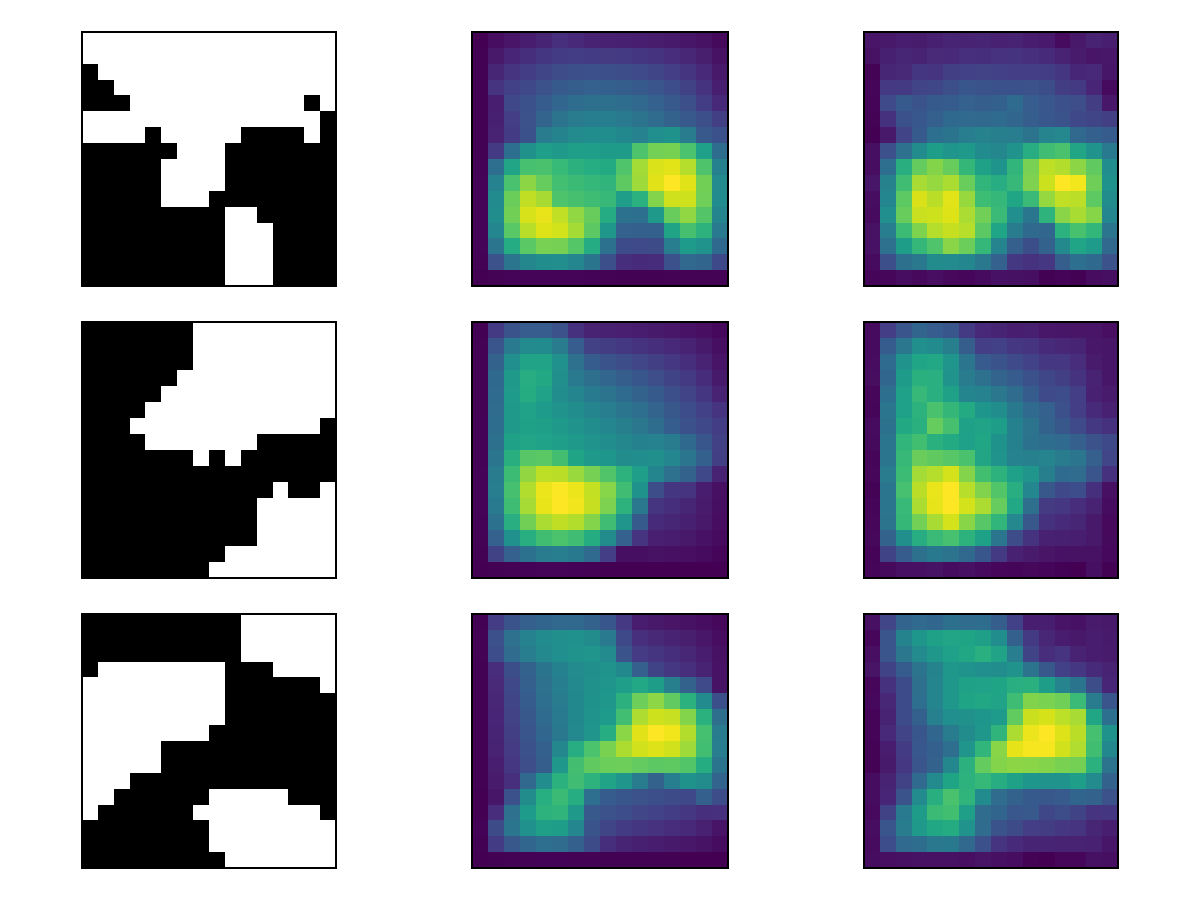

In [50]:
using CairoMakie
cpu = cpu_device()

function create_comparison_figure(inputs, ground_truth, predictions)
    inputs = cpu(inputs)
    ground_truth = cpu(ground_truth)
    predictions = cpu(predictions)
    
    n_samples = size(inputs, 4)
    
    fig = Figure(size=(600, 450))
    
    # Create plot grid with equal spacing and size
    for i in 1:n_samples
        # Create subplot with three horizontal panels
        subfig = GridLayout(fig[i, 1:3])
        
        # Input
        ax1 = Axis(subfig[1, 1], aspect=1)
        hm1 = heatmap!(ax1, inputs[:, :, 1, i], colormap=[:black, :white], interpolate=false)
        hidedecorations!(ax1)
        
        # Ground truth plot
        ax2 = Axis(subfig[1, 2], aspect=1)
        hm2 = heatmap!(ax2, ground_truth[:, :, 1, i], colormap=:viridis, interpolate=false)
        hidedecorations!(ax2)
        
        # Prediction plot
        ax3 = Axis(subfig[1, 3], aspect=1)
        hm3 = heatmap!(ax3, predictions[:, :, 1, i], colormap=:viridis, interpolate=false)
        hidedecorations!(ax3)
        
        # Only add labels to the first row
        if i == 10
            Label(subfig[1, 1], "Input x")
            Label(subfig[1, 2], "Ground-truth y")
            Label(subfig[1, 3], "Model prediction")
        end
    end
    
    return fig
end

i = 1:3
inputs, ground_truth, predictions = x_test[:, :, :, i], y_test[:, :, :, i], pred[:, :, :, i]

# Create and save the figure
fig = create_comparison_figure(inputs, ground_truth, predictions)

## 5. Spherical Fourier Neural Operators <a class="anchor" id="sfno"></a>

* While Fourier Neural Operators have proved highly effective for learning operators between function spaces, they face challenges when applied to spherical geometries.

* The key issue is that regular Fourier transforms implicitly assume flat geometry, leading to artifacts near the poles and incorrect longitudinal periodicity when applied to the sphere.

* The spherical harmonics form a complete orthogonal basis for functions on the sphere $S^2$. They are defined as:

$$Y_l^m(\theta,\phi) = (-1)^m c_l^m P_l^m(\cos\theta)e^{im\phi}$$

where:
* $l$ is the degree
* $m$ is the order, with $-l \leq m \leq l$
* $c_l^m$ are normalization factors
* $P_l^m$ are the associated Legendre polynomials
* $\theta$ is colatitude (0 to $\pi$)
* $\phi$ is longitude (0 to 2$\pi$)
<br>

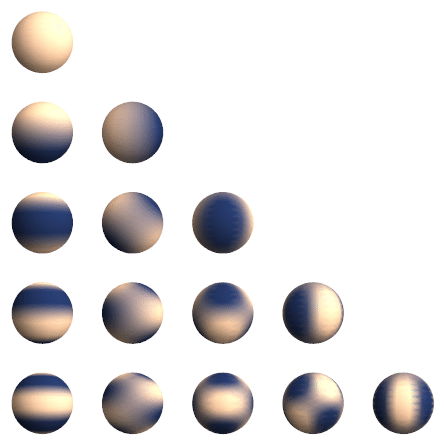

[SpeedyWeather.jl docs](https://speedyweather.github.io/SpeedyWeather.jl/stable/spectral_transform/#Spectral-packing)

* In this animation, every row represents a degree $l \geq 0$, starting from $l = 0$ at the top. Every column represents an order $m \geq 0$, starting from $m=0$ on the left. 
<br>

* Just as the Fourier transform decomposes functions into sums of complex exponentials, the Spherical Harmonic Transform (SHT) decomposes functions on the sphere into spherical harmonics:

$$f(\theta,\phi) = \sum_{l=0}^{\infty} \sum_{m=-l}^l \hat{f}(l,m)Y_l^m(\theta,\phi)$$

with coefficients:

$$
\hat{f}(l,m) = \int_{S^2} f(\theta,\phi)\overline{Y_l^m}(\theta,\phi) d\Omega
$$

where $d\Omega = \sin\theta d\theta d\phi$ is the surface element on the sphere.

* The key innovation in SFNOs is using spherical convolution instead of regular convolution. For functions $f,g$ on $S^2$, their convolution is defined as:

$$
(f * g)(x) = \int_{R \in SO(3)} f(Rn)g(R^{-1}x)dR
$$

where:
- $SO(3)$ is the group of rotations in 3D
- $n$ is the north pole
- $R$ is a rotation matrix
- $dR$ is the Haar measure on $SO(3)$

* This formulation respects the spherical geometry and leads to a convolution theorem on the sphere:

$$
\widehat{(f * g)}(l,m) = 2\pi\sqrt{\frac{4\pi}{2l+1}}\hat{f}(l,m)\hat{g}(l,0)
$$

* **The SFNO replaces the Fourier layer in traditional FNOs with a spherical Fourier layer**:

$$
\mathcal{K}_\theta[u] = \mathcal{F}^{-1}[\tilde{\kappa}_\theta \cdot \mathcal{F}[u]]
$$

where:
- $\mathcal{F}$ is now the SHT
- $\tilde{\kappa}_\theta$ are learned filters in spherical harmonic space
- The multiplication respects spherical convolution

* Key properties:
1. Resolution invariance is preserved
2. Equivariance to rotations
3. Correct handling of poles and periodicity
4. Maintains the computational efficiency of FFT through fast SHT algorithms


* SFNOs avoid artifacts at the poles:
 
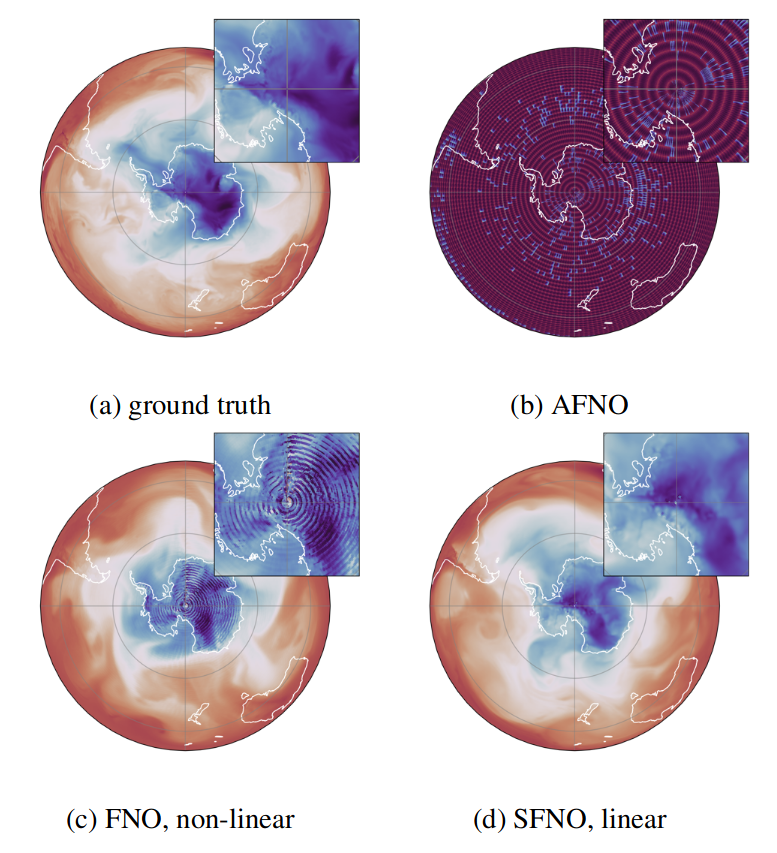

## 6. Further Reading <a class="anchor" id="further-reading"></a>
1. [Azizzadenesheli, K. et al. Neural operators for accelerating scientific simulations and design. Nat Rev Phys 6, 320–328 (2024). ](https://www.nature.com/articles/s42254-024-00712-5)
2. [Li et al. Fourier Neural Operator for Parametric Partial Differential Equations (2021)](https://openreview.net/forum?id=c8P9NQVtmnO)
3. [Bonev et al. Spherical Fourier Neural Operators: Learning Stable Dynamics on the Sphere](https://proceedings.mlr.press/v202/bonev23a.html)